In [1]:
import matplotlib
from matplotlib import pyplot as plt
from numpy import *
import numpy as np
import random
import scipy.io
import sklearn.utils

f1 = scipy.io.loadmat('train.mat')
%matplotlib inline

In [754]:
#Input Layer 28x28x1
#Convolution Layer
#Output Layer 10x1
#10 filters, 3x3x1


def reshape_x(x): #add bias row to NN input
    X = np.reshape(x,(len(x),len(x.T)**2))
    X = X/np.max(X)
    return X

def reshape_y(y,outputSize): #change y from a single value to an array of 10 values corresponding to output 
    tempy = np.zeros((len(y),outputSize))
    for i,r in enumerate(y):
        tempy[i][r[0]] = 1
    return tempy


class NeuralNet(): #single convNet with a single fully connected neural layer, pool layer?
    def __init__(self,input_Size,filter_Count,filtered_Size,hidden_Size,output_Size): #add bias later
        self.filter_Count = filter_Count
        self.input_Size = input_Size
        self.filtered_Size = filtered_Size
        self.hidden_Size = hidden_Size
        self.output_Size = output_Size

        filter_Weights = np.random.normal(0,0.01,input_Size*filter_Count)
        self.filter_Weights = np.reshape(filter_Weights,(filter_Count,input_Size))

        V = np.random.normal(0,0.01,hidden_Size*(filtered_Size))
        self.V = np.reshape(V,(hidden_Size,filtered_Size))

        W = np.random.normal(0,0.01,output_Size*(hidden_Size))
        self.W = np.reshape(W,(output_Size,hidden_Size))
        
    def forward(self, inputs):
        r = random.randint(0,self.filter_Count-1)
        filter_train = np.array([self.filter_Weights[r]])
        
        self.conv_Vals = np.dot(filter_train,inputs.T) # FX
        self.activation_conv = self.activation_fnc1(self.conv_Vals).T # f(FX)

        self.hidden_Vals = np.dot(self.V,self.activation_conv) # Vf(FX)
        self.activation_H = self.activation_fnc2(self.hidden_Vals) # f(Vf(FX))
   
        
        self.pre_guess = np.dot(self.W,self.activation_H)  # Wf(Vf(FX))
        self.guess = self.activation_fnc3(self.pre_guess)  # f(Wf(Vf(FX)))
        
        
        
    def meanSquared(self,inputs,outputs):
        self.forward(inputs)
        return sum((outputs-self.guess)**2)/2
    
    
    def meanSquaredBack(self,inputs,outputs):
       
        self.forward(inputs) # f(Wf(Vf(FX)))
        
        back1 = (-outputs+self.guess)*self.activation_fnc1(self.pre_guess,True) #(-y+y_h)f'(Wf(Vf(FX)))
        dW = np.dot(back1,self.activation_H.T) # (-y+y_h)f'(Wf(Vf(FX))) f(Vf(FX))
        
        back2 = np.dot(self.W.T,back1)*self.activation_fnc2(self.hidden_Vals,True) #(-y+y_h)f'(Wf(Vf(FX))) W  f'(Vf(FX))
        dV = np.dot(back2,self.activation_conv.T) #(-y+y_h)f'(Wf(Vf(FX))) W  f'(Vf(FX)) f(FX)
        
        back3 = np.dot(self.V.T,back2).T*self.activation_fnc3(self.conv_Vals,True) #(-y+y_h)f'(Wf(Vf(FX))) W  f'(Vf(FX)) V f'(FX)
        dF = np.dot(back3,inputs) #(-y+y_h)f'(Wf(Vf(FX))) W  f'(Vf(FX)) V f'(FX) X
        return dF, dV, dW
        
        
    def update_Weights(self, updates, step_size):
        self.filter_Weights -= updates[0]*step_size
        self.V -= updates[1]*step_size
        self.W -= updates[2]*step_size
        
        
    def activation_fnc1(self, z, deriv=False): #currently sigmoid
        a = None
        if deriv:
            a = (1-(1+np.exp(-z))**-1)/(1+np.exp(-z))
        else:
            a = (1+np.exp(-z))**-1
        nans = isnan(a)
        a[nans] = 0
        return a
    
    def activation_fnc2(self, z, deriv=False): #currently tanh
        a = None
        if deriv:
            a = 1-np.tanh(z)**2
            
        else:
            a = np.tanh(z)
        nans = isnan(a)
        a[nans] = 0
        return a
    
    def activation_fnc3(self, z, deriv=False): #currently tanh
        a = None
        if deriv:
            a = 1-np.tanh(z)**2
        else:
            a = np.tanh(z)
        nans = isnan(a)
        a[nans] = 0
        return a
    
    def train(self, inputs, outputs, iters, feat_size,e):
            
        self.inputs = inputs
        
        self.outputs = reshape_y(outputs,10)
        
        for i in range(iters):
            r = random.randint(0,len(inputs)-1)
            dp = im2col(inputs[r].reshape(28,28),feat_size,feat_size) #change to vars
#             dp = np.array([inputs[r]])
            dpl = np.array([self.outputs[r]]).T
            deriv = self.meanSquaredBack(dp,dpl)
            if i % 1000 == 0:
                count = 0
                for i in range(100):
                    r = random.randint(0,len(inputs)-1)
                    d = im2col(inputs[r].reshape(28,28),feat_size,feat_size)
                    a = np.array([self.outputs[r]]).T
                    count += self.meanSquared(d,a)
                print(count)
            self.update_Weights(deriv,e)
    
    
    def predict(self,inputs,box):
        dp = im2col(inputs.reshape(28,28),box,box) #change to vars
        self.forward(dp)
#         self.forward(inputs)
        return self.guess
    

In [755]:
def im2col(matrix,box_width,box_height,stride=1): #need to fix stride
    height = len(matrix)
    width = len(matrix.T)

    ret_height = box_width*box_height
    ret_width = int(((width-box_width)/stride+1)**2)
    
    
    im_matrix = np.zeros((1,box_width*box_height))
    for i in range(height):
        for j in range(width):
            if (j+box_width <= width) and (i+box_height <= height):
                im_matrix = np.append(im_matrix,
                                      matrix[i:i+box_height,j:j+box_width].reshape(box_width*box_height))
            else:
                break
    val_matrix = im_matrix.T[box_width*box_height:]
    ret_matrix = val_matrix.reshape((ret_width,ret_height))
    return ret_matrix
    

In [756]:
y = f1['train_labels']
X = np.swapaxes(f1['train_images'],1,0).T

X = reshape_x(X)
X,y = sklearn.utils.shuffle(X,y,random_state=0)

In [ ]:
box = 5
meanNeural = NeuralNet(box**2,25,576,500,10)
meanNeural.train(X,y,50000,box,np.exp(-3))

50.0386871105
35.0733587695
30.6811170917
28.3040499962
28.7373340899
28.1477494799
27.9454965014
27.6245598045

In [730]:
count=0
for i in range(100):
    count += int(np.argmax(meanNeural.predict(X[i],box))==y[i])
print(count/100)

0.7


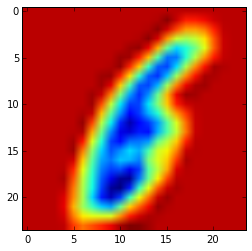

In [741]:
plt.imshow(np.dot(im2col(X[100].reshape(28,28),5,5),meanNeural.filter_Weights.T).reshape(24,24))